# Exercise Fourteen: Project Design Starter
In this exercise, you'll be planning out a complex project. You'll draw in some code, but focus on commenting to describe your project structure. The sample document below will guide you through organizing and annotating your project design. The primary components you'll include are:

- Dependencies: What modules will your project need?
- Collection: Where is your data coming from?
- Processing: How will you format and process your data?
- Analysis: What techniques will you use to understand your data?
- Visualization: How will you visualize and explore your data?

# Project Overview
I plan on extracting information from Twitter using #BlerDcon. BlerDcon is a convention — the event’s name signals that it specifically caters to blerds (black nerds), BlerDCon is an inclusive space for all POC, LGBTQ+, female, and disabled fans. Pulling data from the 2021 convention, I seek to gather more information and insight into the topics dicussed around this venue and the sentiments of the participants. 

# Dependencies
Importing modules to extract data from hastags on twitter, compile that information into a digestible list, and then use that info to create visualizations for the data.

In [ ]:
# Importing Config to pull credentials for Twitter API
import configparser

#Importing Twitter API
import tweepy

import datetime

import csv

#Importing to help extract data
import requests
from bs4 import BeautifulSoup

#Importing to map out geographical locations of responses
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#importing to plot findings in visualization
import matplotlib.pyplot as plt

#importing for map visualization
import cartopy.crs as ccrs
from matplotlib.patches import Circle

#importing to assist in compliling 
import re

#Importing for punctuation
from nltk.tokenize import WordPunctTokenizer

#importing to make a wordcloud for visualizations
from wordcloud import WordCloud, STOPWORDS

#To turn work cloud into an image
import numpy as np
from PIL import Image
import random

#Importing to gather sentiments from comments
import nltk.data
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize

# Importing Pandas to handle collected Twitter data 
import pandas as pd

import os

In [81]:
'''import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests'''

# Collection
Collecting data from recent 2021 convention hastag #BlerDcon. Starting date from pull will begin 01-01-2021 to current time. This can be changed later to look into other year conventions. 

In [89]:
#Pulling credentials file, so Twiiter Developer account can be accessed
CONFIG = configparser.ConfigParser()
CONFIG.read('credentials.ini')

#Tweepy
auth = tweepy.OAuthHandler(CONFIG['DEFAULT']['consumer_key'], CONFIG['DEFAULT']['consumer_secret'])
auth.set_access_token(CONFIG['DEFAULT']['access_token'], CONFIG['DEFAULT']['access_token_secret'])

api = tweepy.API(auth, wait_on_rate_limit=True)

public_tweets = api.home_timeline()
for tweet in public_tweets:
    #dont need to see everything
    print(tweet.text [0:10])

@ me. Cuz 
stay away 
WHY DO POW
It's simpl
Have you s
So when @A
stop likin
Eddie Mekk
Pulse http
RT @CITRUS
Can you di
"A cocaine
RT @cruxin
RT @Joseph
I’m sure I
If you’re 
This is ob
For a retr
Students 👇
Starbucks 


In [90]:
#pulling info in from specific hashtag
search_words = "#BlerDCon"
date_since = "2010-01-01"
tweets = tweepy.Cursor(api.search_tweets,
              q=search_words, lang="en").items(300)

In [ ]:
'''# Trying another way around Twitter. Found Youtube video discussing topic -- will pull comments from there.
import urllib.request, urllib.error, urllib.parse

url = 'https://www.lipstickalley.com/threads/blerdcon-a-white-girl-wins-the-cosplay-event-is-that-ok.4605659/'

response = urllib.request.urlopen(url)
HTML = response.read()

print(HTML[0: 2000])'''

In [ ]:
'''contents = str(HTML)
startLoc = contents.find("comments")
endLoc = contents.find("<div class='answererUserIcon'>")

print(startLoc)
print(endLoc)

contents = contents[startLoc: endLoc]
print(contents[0: 2000])'''

# Processing
After your data has been collected or imported, store it in a format that works for your purposes. This can vary: for Twitter analysis, it might be a Pandas dataframe, while for text, you might build a document term matrix.

In [91]:
#using pandas to sort tweets
tweets_sorted = [[tweet.user.screen_name, tweet.geo, tweet.user.location, tweet.text] for tweet in tweets]

#caluculating coordinates of Tweets -- doesnt look like too many locations (may not use for data set)
tdf = pd.DataFrame(data=tweets_sorted, columns=['user', 'coordinates','location', 'tweet'])
print(tdf)

#may need to look for word count instead

              user coordinates                  location  \
0      LadySOULdja        None  Somewhere funkin' around   
1       notboosuwu        None              he/him 19yrs   
2  fluffybunnyluna        None             Michigan, USA   
3         uwumicos        None                             

                                               tweet  
0  @TheBlackLuffy93 You gotta go to #blerdcon wit...  
1  RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...  
2  RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...  
3  RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...  


In [94]:
'''df = pd.DataFrame(output)
df.to_csv('output.csv')'''

In [ ]:
'''#need to organize CSV better then this function will work better

df = pd.read_csv('output.csv')
# Prints how pd will structure data types
print(df.dtypes)'''

In [ ]:
'''df = pd.read_csv('output.csv')
df.head()'''


In [ ]:
'''#trying to read CSV another way
f = open('output.csv', 'r')
text = f.read()
f.close()

#split_string
word_bag = text.split()
print(word_bag[0:100])

#make lower case
text = text.lower()
word_bag = text.split()
print(word_bag[0:100])'''

# Analysis
Would like to analyze the CSV file for common key terms and number of times a topic is mentioned. From their try to build out sentiments of users. 

In [96]:
locs = tdf['location'].value_counts()
print(locs)

Somewhere funkin' around    1
he/him 19yrs                1
Michigan, USA               1
                            1
Name: location, dtype: int64


In [97]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='twitter-analysis-client')
limited = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def find_location(row):
    place = row['location']
    location = limited(place)
    
    if location != None:
        return location.latitude, location.longitude
    else:
        return "Not Found", "Not Found"

tdf[['latitude','longitude']] = tdf.apply(find_location, axis="columns", result_type="expand")
tdf

,user,coordinates,location,tweet,latitude,longitude
0,LadySOULdja,None,Somewhere funkin' around,@TheBlackLuffy93 You gotta go to #blerdcon wit...,Not Found,Not Found
1,notboosuwu,None,he/him 19yrs,RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...,Not Found,Not Found
2,fluffybunnyluna,None,"Michigan, USA",RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...,43.621195,-84.682435
3,uwumicos,None,,RT @SailorLeone: Curly hero ❤️‍🔥RED RIOT❤️‍🔥\n...,Not Found,Not Found


In [98]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (20, 10)

# Visualization
The goal was to create a word cloud with common topics from the hashtag and place it over the logo for the conference. 

In [100]:
counter = tdf.groupby(['latitude','longitude']).size().reset_index().rename(columns={0:'count'})

print(counter)

    latitude  longitude  count
0  43.621195 -84.682435      1
1  Not Found  Not Found      3


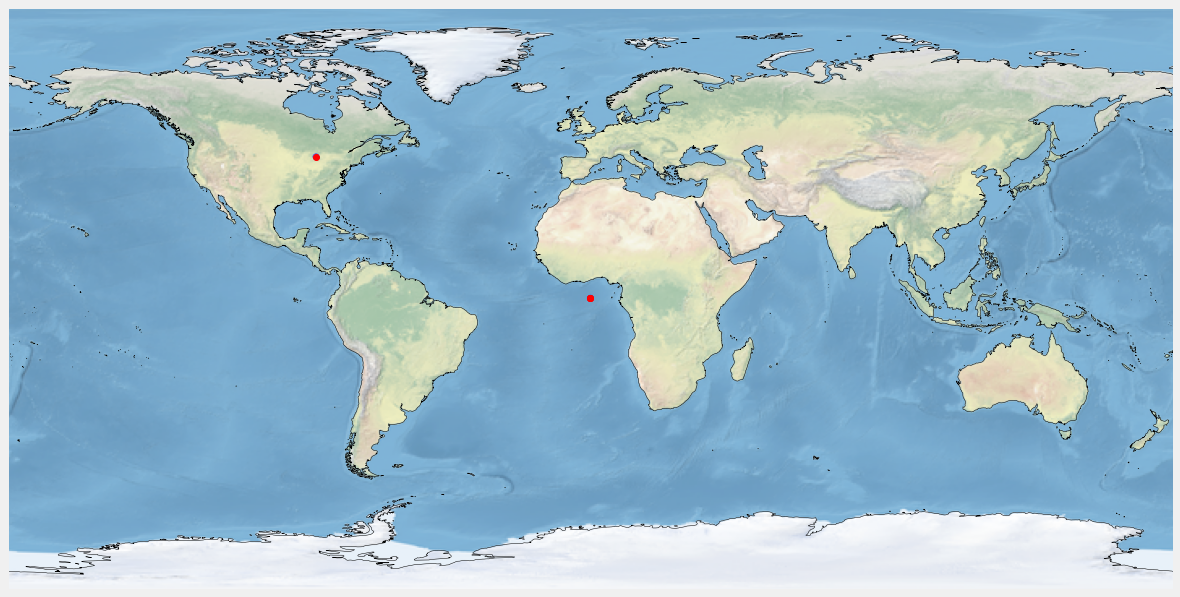

In [101]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
# plot individual locations                                                                                                       
for i in range(0, len(lats)):
    ax.plot(longs[i], lats[i], 'ro', transform=ccrs.PlateCarree())
                           
# add coastlines for reference                                                                                                
ax.coastlines(resolution='50m')
ax.set_global()
def get_radius(freq):
    if freq < 5:
        return 1
    elif freq < 10:
        return 2
    elif freq >= 10:
        return 3
# plot count of tweets per location

colLats = counter['latitude']
colLongs = counter['longitude']
colCounts = counter['count']

for i in range(0, len(counter)):
    ax.add_patch(Circle(xy=[colLongs[i], colLats[i]], radius=get_radius(colCounts[i]), color='blue',alpha=0.5, transform=ccrs.PlateCarree()))
